# Intracranial EEG data for connectivity analyses

This Jupyter Notebook walks through an example where iEEG data saved in the Brain Imaging Data Structure (BIDS) are loaded and visualized. The dataset used in this exmaple consists of 74 patients age 4-51 years old where Cortico-Cortical Evoked Potentials (CCEPs) were measured with Electro-CorticoGraphy (ECoG) during single pulse electrical stimulation. For a detailed description see:

- Developmental trajectory of transmission speed in the human brain. D. van Blooijs¹, M.A. van den Boom¹, J.F. van der Aar, G.J.M. Huiskamp, G. Castegnaro, M. Demuru, W.J.E.M. Zweiphenning, P. van Eijsden, K. J. Miller, F.S.S. Leijten, D. Hermes, Nature Neuroscience, 2023, https://doi.org/10.1038/s41593-023-01272-0
¹ these authors contributed equally.

This dataset is part of the RESPect (Registry for Epilepsy Surgery Patients) database, a dataset recorded at the University Medical Center of Utrecht, the Netherlands. The study was approved by the Medical Ethical Committee from the UMC Utrecht. This project was supported by the National Institute Of Mental Health of the National Institutes of Health under Award Number R01MH122258. The content is solely the responsibility of the authors and does not necessarily represent the official views of the National Institutes of Health

This Jupyter Notebook was written by Dora Hermes (2024).

# Overview

This notebook will walk you through the following steps to visualize iEEG data in BIDS format:
1. Loading python packages
2. Loading BIDS metadata
3. Visualizing iEEG electrode locations
4. Loading and visualizing iEEG data



# 1. Getting started with the Python environment and packages
Before getting started, you need to have the necessary software installed and data downloaded. 

An iEEG dataset formatted according to the Brain Imaging Data Structure used this tutorial can be downloaded from OpenNeuro. We will work with a single subject.
https://openneuro.org/datasets/ds004080


## 1.1 Importing python packages

We use several Python packages, and the following allow us to work with the BIDS dataset in this notebook:
 - [PyBIDS](https://bids-standard.github.io/pybids/#) ([Yarkoni et al., 2019](https://joss.theoj.org/papers/10.21105/joss.01294)), a Python library to centralize interactions with BIDS datasets. For more information on BIDS, see: [https://bids.neuroimaging.io](https://bids.neuroimaging.io).
 - [IeegPrep](https://pypi.org/project/ieegprep/), a python library to read, pre-process and epoch Intracranial Electroencephalography (iEEG) data that is structured according to the Brain Imaging Data Structure (BIDS)

In [1]:
# packages importing
import os

# for scientific computing and data visualization 
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import NMF
import itertools
from tqdm import tqdm

# for handling neuroimaging data
import bids
from nilearn import plotting

# for handling iEEG data
from ieegprep import IeegDataReader
from ieegprep import load_event_info, load_channel_info, load_data_epochs


%matplotlib inline

# 2. Loading and checking the BIDS data and metadata

An example CCEP dataset is available on OpenNeuro ([link](https://openneuro.org/datasets/ds004080). This dataset is formatted according to the Brain Imaging Data Structure ([BIDS](https://bids.neuroimaging.io/)). We will work with one subject in this tutorial. 

This dataset includes an electrocorticography (ECoG) dataset with single pulse stimulation, and accompanying metadata, such as electrode positions, channel information, stimulation events etc.

In [2]:
# change this path to the full hardcoded BIDS data path to be analyzed
BIDS_dataset_path = '/home/jovyan/shared/ds004080' # '/full/path/to/Basis_profile_curve/data'

## 2.1 Load BIDS metadata

We use pyBIDS to initialize a BIDSLayout: this will index the files and metadata under the specified root folder (should be 1 subject, 1 session, 1 run).

In [3]:
# Initialize the layout
layout = bids.BIDSLayout(BIDS_dataset_path)

# Print some basic information about the layout
print(layout)
print('Subjects in this BIDS layout:', layout.get_subjects())

all_files = layout.get()
df_layout = layout.to_df()

BIDS Layout: .../home/jovyan/shared/ds004080 | Subjects: 74 | Sessions: 74 | Runs: 117
Subjects in this BIDS layout: ['ccepAgeUMCU01', 'ccepAgeUMCU02', 'ccepAgeUMCU03', 'ccepAgeUMCU04', 'ccepAgeUMCU05', 'ccepAgeUMCU06', 'ccepAgeUMCU07', 'ccepAgeUMCU08', 'ccepAgeUMCU09', 'ccepAgeUMCU10', 'ccepAgeUMCU11', 'ccepAgeUMCU12', 'ccepAgeUMCU13', 'ccepAgeUMCU14', 'ccepAgeUMCU15', 'ccepAgeUMCU16', 'ccepAgeUMCU17', 'ccepAgeUMCU18', 'ccepAgeUMCU19', 'ccepAgeUMCU20', 'ccepAgeUMCU21', 'ccepAgeUMCU22', 'ccepAgeUMCU23', 'ccepAgeUMCU24', 'ccepAgeUMCU25', 'ccepAgeUMCU26', 'ccepAgeUMCU27', 'ccepAgeUMCU28', 'ccepAgeUMCU29', 'ccepAgeUMCU30', 'ccepAgeUMCU31', 'ccepAgeUMCU32', 'ccepAgeUMCU33', 'ccepAgeUMCU34', 'ccepAgeUMCU35', 'ccepAgeUMCU36', 'ccepAgeUMCU37', 'ccepAgeUMCU38', 'ccepAgeUMCU39', 'ccepAgeUMCU40', 'ccepAgeUMCU41', 'ccepAgeUMCU42', 'ccepAgeUMCU43', 'ccepAgeUMCU44', 'ccepAgeUMCU45', 'ccepAgeUMCU46', 'ccepAgeUMCU47', 'ccepAgeUMCU48', 'ccepAgeUMCU49', 'ccepAgeUMCU50', 'ccepAgeUMCU51', 'ccepAgeUMCU52'

## 2.2 Select run to analyze

User input regarding the subject, session and task to be analyzed:

In [4]:
# Change this to make sure it fits your data
bids_sub = 'ccepAgeUMCU33' # The subject label
bids_run = '021231' # The run name

# bids_sub = 'ccepAgeUMCU35' # The subject label
# bids_run = '021624' # The run name

bids_ses = '1' # The session label
bids_task = 'SPESclin' # The task name


if bids_sub == 'ccepAgeUMCU33': 
    sub_stim_site = 'C03-C04'
elif bids_sub == 'ccepAgeUMCU35': 
    sub_stim_site = 'TOB2-TOB3'
    

Next we can load filenames and metadata files needed for this analysis from the BIDSLayout:

In [5]:
# Retrieve file names
ieegName = layout.get(subject=bids_sub, session=bids_ses, run=bids_run, task=bids_task, suffix='ieeg', extension="vhdr")
print('We will load the following iEEG data:',ieegName)
                
dataJson = layout.get(subject=bids_sub, session=bids_ses, run=bids_run, task=bids_task, suffix='ieeg', extension="json")[0]
print('\nSidecar JSON (*_ieeg.json):', dataJson)

channels_tsv_name = layout.get(subject=bids_sub, session=bids_ses, run=bids_run, task=bids_task, suffix='channels', extension = "tsv")[0]
print('\nChannels description (*_channels.tsv):', channels_tsv_name)

events_tsv_name = layout.get(subject=bids_sub, session=bids_ses, run=bids_run, task=bids_task, suffix='events', extension = "tsv")[0]
print('\nevents_tsv_name:', events_tsv_name)

electrodes_tsv_name = layout.get(subject=bids_sub, session=bids_ses, suffix='electrodes', extension = "tsv")[0]
print('\nElectrode description (*_electrodes.tsv):', electrodes_tsv_name)


We will load the following iEEG data: [<BIDSFile filename='/home/jovyan/shared/ds004080/sub-ccepAgeUMCU33/ses-1/ieeg/sub-ccepAgeUMCU33_ses-1_task-SPESclin_run-021231_ieeg.vhdr'>]

Sidecar JSON (*_ieeg.json): <BIDSJSONFile filename='/home/jovyan/shared/ds004080/sub-ccepAgeUMCU33/ses-1/ieeg/sub-ccepAgeUMCU33_ses-1_task-SPESclin_run-021231_ieeg.json'>

Channels description (*_channels.tsv): <BIDSDataFile filename='/home/jovyan/shared/ds004080/sub-ccepAgeUMCU33/ses-1/ieeg/sub-ccepAgeUMCU33_ses-1_task-SPESclin_run-021231_channels.tsv'>

events_tsv_name: <BIDSDataFile filename='/home/jovyan/shared/ds004080/sub-ccepAgeUMCU33/ses-1/ieeg/sub-ccepAgeUMCU33_ses-1_task-SPESclin_run-021231_events.tsv'>

Electrode description (*_electrodes.tsv): <BIDSDataFile filename='/home/jovyan/shared/ds004080/sub-ccepAgeUMCU33/ses-1/ieeg/sub-ccepAgeUMCU33_ses-1_electrodes.tsv'>


We use the pandas.DataFrame.head function to quickly test if our files have the expected data in them.

In [6]:
df_channels = channels_tsv_name.get_df()  # Get file contents as a pandas DataFrame (only works for TSV files)
# np.shape(df_channels)
df_channels.head(5)

,name,type,units,low_cutoff,high_cutoff,reference,group,sampling_frequency,notch,status,status_description
0,C01,ECOG,µV,468,0.15,G2,grid,2048,NaN,good,included
1,C02,ECOG,µV,468,0.15,G2,grid,2048,NaN,good,included
2,C03,ECOG,µV,468,0.15,G2,grid,2048,NaN,good,included
3,C04,ECOG,µV,468,0.15,G2,grid,2048,NaN,good,included
4,C05,ECOG,µV,468,0.15,G2,grid,2048,NaN,good,included


In [7]:
df_events = events_tsv_name.get_df()  # Get file contents as a pandas DataFrame (only works for TSV files)
df_events[30:40]

,onset,duration,trial_type,sub_type,electrodes_involved_onset,electrodes_involved_offset,offset,sample_start,sample_end,electrical_stimulation_type,electrical_stimulation_site,electrical_stimulation_current,electrical_stimulation_frequency,electrical_stimulation_pulsewidth,notes
30,115.567871,0.001,electrical_stimulation,SPESclin,NaN,NaN,115.568871,236683,236685.048,monophasic,C02-C03,0.008,0.2,0.001,NaN
31,120.567871,0.001,electrical_stimulation,SPESclin,NaN,NaN,120.568871,246923,246925.048,monophasic,C02-C03,0.008,0.2,0.001,NaN
32,125.567871,0.001,electrical_stimulation,SPESclin,NaN,NaN,125.568871,257163,257165.048,monophasic,C02-C03,0.008,0.2,0.001,NaN
33,130.567871,0.001,electrical_stimulation,SPESclin,NaN,NaN,130.568871,267403,267405.048,monophasic,C02-C03,0.008,0.2,0.001,NaN
34,135.567871,0.001,electrical_stimulation,SPESclin,NaN,NaN,135.568871,277643,277645.048,monophasic,C02-C03,0.008,0.2,0.001,NaN
35,140.567871,0.001,electrical_stimulation,SPESclin,NaN,NaN,140.568871,287883,287885.048,monophasic,C02-C03,0.008,0.2,0.001,NaN
36,145.567871,0.001,electrical_stimulation,SPESclin,NaN,NaN,145.568871,298123,298125.048,monophasic,C02-C03,0.008,0.2,0.001,NaN
37,152.357422,0.001,electrical_stimulation,SPESclin,NaN,NaN,152.358422,312028,312030.048,monophasic,C03-C04,0.008,0.2,0.001,NaN
38,157.357422,0.001,electrical_stimulation,SPESclin,NaN,NaN,157.358422,322268,322270.048,monophasic,C03-C04,0.008,0.2,0.001,NaN
39,162.357422,0.001,electrical_stimulation,SPESclin,NaN,NaN,162.358422,332508,332510.048,monophasic,C03-C04,0.008,0.2,0.001,NaN


In [8]:
df_electrodes = electrodes_tsv_name.get_df()  # Get file contents as a pandas DataFrame (only works for TSV files)
df_electrodes.head()

,name,x,y,z,size,material,manufacturer,group,hemisphere,silicon,soz,resected,edge,Destrieux_label,Destrieux_label_text
0,C01,-45.978340,-83.947266,6.868704,4.2,Platinum,AdTech,grid,L,no,no,no,no,19.0,G_occipital_middle
1,C02,-52.322868,-64.891953,5.330915,4.2,Platinum,AdTech,grid,L,no,no,no,no,38.0,G_temporal_middle
2,C03,-54.796021,-63.431690,11.275980,4.2,Platinum,AdTech,grid,L,no,no,no,no,38.0,G_temporal_middle
3,C04,-50.705036,-53.113731,30.192728,4.2,Platinum,AdTech,grid,L,no,no,no,no,55.0,S_interm_prim-Jensen
4,C05,-55.374535,-50.551937,36.100731,4.2,Platinum,AdTech,grid,L,no,no,no,no,26.0,G_pariet_inf-Supramar


# 3. Render brain surface

Render electrode labels in MNI space. This should open a separate browser window.

In [9]:
marker_colors=[]

xyz_list = df_electrodes[['x', 'y','z']].values.tolist()
electrodeName_list = df_electrodes[['name']].name.values.tolist()

# gray out bad channels
for cords_name in electrodeName_list:
    if df_channels[df_channels.name == cords_name].status.values[0] == 'good':
        marker_colors.append('red')
    else:
        marker_colors.append('gray')

view = plotting.view_markers(marker_coords=xyz_list, marker_labels=electrodeName_list, marker_size=7.5,
                             marker_color=marker_colors, title='Electrodes in MNI space rendered on a standard brain') # Insert a 3d plot of markers in a brain

In [10]:
view.save_as_html('viewer.html')

# 4. Loading and preprocessing data

Load some data

In [11]:
ieegFile = f'{BIDS_dataset_path}/sub-{bids_sub}/ses-{bids_ses}/ieeg/sub-{bids_sub}_ses-{bids_ses}_task-{bids_task}_run-{bids_run}_ieeg.vhdr';

# get channels and events to load
channels = load_channel_info(channels_tsv_name)
events   = load_event_info(events_tsv_name)

onset = np.array(events['onset'])
stim_site = np.array(events['electrical_stimulation_site'])

these_events = (stim_site == sub_stim_site) 

these_onsets = onset[these_events]

# time limits for epochs
epoch_limits = [-1,2];

# retrieve epoched data specifying the epoch window and baseline normalization
[srate, epochs] = load_data_epochs( ieegFile,
                                    retrieve_channels = channels['name'],
                                    onsets            = these_onsets,
                                    trial_epoch       = (epoch_limits[0], epoch_limits[1]),                         #  -1s < onset < 2s  
                                    baseline_norm     = 'Median',
                                    baseline_epoch    = (-1, -0.1))

# create a time vector to match the data
tt = np.arange(start=epoch_limits[0], stop=epoch_limits[1], step=1/srate)
tt = np.delete(tt, 0)

# check shape
epochs.shape


Progress: |██████████████████████████████████████████████████| 100.0% Complete


(133, 10, 6144)

/tmp/ipykernel_588/432810282.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


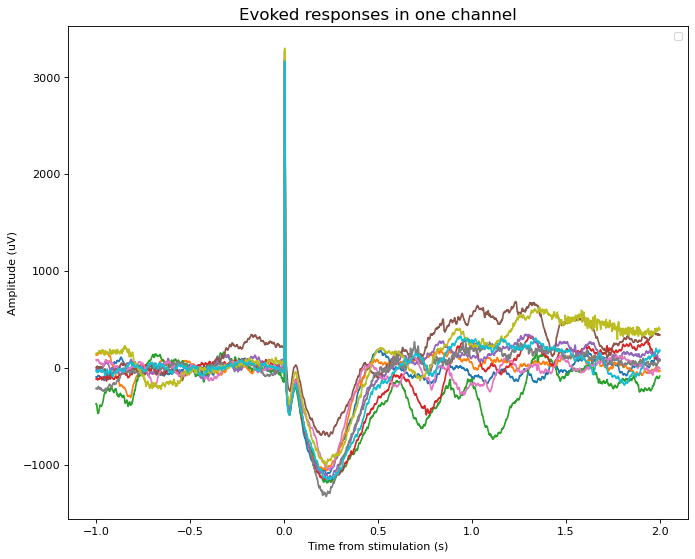

In [12]:
# Plot all trials from a single electrode

# let's look at response in channel 10 (UMCU33, stim 'C03-C04') or channel 13 or 33 (UMCU35, stim 'TOB2-TOB3')
this_measured_channel = np.transpose(epochs[10,:,:])

# plot
colors = iter(cm.tab10(np.linspace(0, 1, 10)))
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(tt, this_measured_channel)
plt.xlabel('Time from stimulation (s)')
plt.ylabel('Amplitude (uV)')
plt.title('Evoked responses in one channel',fontsize=15)
plt.legend()

plt.show()

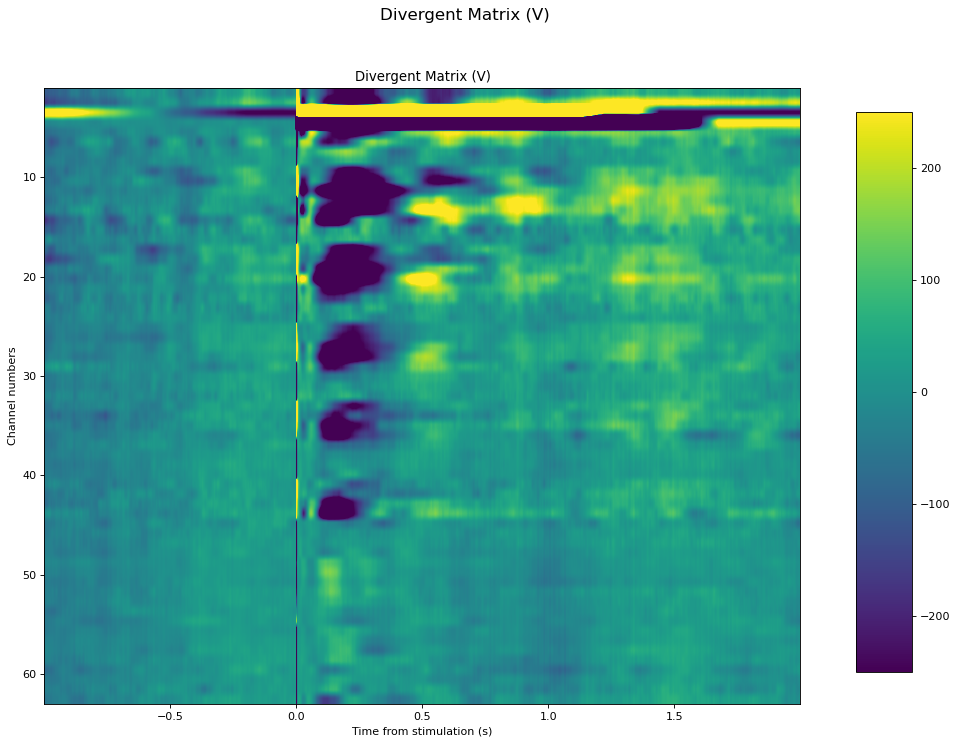

In [13]:
"""
Plot average stimulation evoked responses in all good channels
"""

V = np.mean(epochs, axis=1)

channel_status = np.array(channels['status'])
channel_type = np.array(channels['type'])
good_channels = (channel_status=='good') & (channel_type=='ECOG')

V_goodchannels = V[good_channels, :]

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10), dpi=80)

fig.suptitle('Divergent Matrix (V)',fontsize= 15)

im = ax1.imshow(V_goodchannels, aspect='auto', extent=[tt[0], tt[-1], V_goodchannels.shape[0], 1], vmin=-250, vmax=250)
ax1.set_xlabel('Time from stimulation (s)')
ax1.set_ylabel('Channel numbers')
ax1.set_title('Divergent Matrix (V)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()